In [13]:
%matplotlib inline

Introduction to Machine Learning
===============

There are a few key components in a standard machine learning problem.

Data
--------
We are given data $n$ samples of data: a collection of features and they're corresponding labels. The data is typically separated into to matrices $X$ and $y$ of size $n \times d$ and $n \times 1$, respectively, where $d$ is the number of features per data point.

For example, if I am trying to build a model to predict house prices, I could collect data on the # of bathrooms, # of bedrooms, total square feet, etc. These are all examples of features. 

Typically, we will split the data into a training set and a test set. We train the model using the training set, and then evaluate how well the model does using the test set. This is to make sure that our model is not "memorizing" the training set and is able to generalize well to data it has not seen before.

Model
--------
There are many models to choose from in ML. We will just be going over three main ones - linear regression, fully connected neural nets, and convolutional neural nets. A model just takes in some input, and outputs a number (or many numbers). 

For example, going back to the house price prediction example, the model would take in a list of features, and output a predicted price.

Loss Function
--------
The loss function provides a way to measure how accurate/inaccurate the model is. For regression, we typically use squared error, defined as
$$\text{error} = \frac{1}{2}\sum_{i=1}^n (y_i - \hat{y}_i)^2$$
where $n$ is the number of training examples, $y_i$ is the true label for the $i$th sample, and $\hat{y}_i$ is the predicted label for the $i$th sample. We want to optimize the model to have a low squared error.

Parameter Updates
--------
Let's say that our model is a linear model, i.e. $$\hat{y} = wx + b$$ $w$ and $b$ are initialized randomly, and we want to adjust these parameters to fit the true model of the data. Since we are using MSE as an intermediary to measure how accurate the model is, we can adjust the parameters to decrease the loss. This is where derivatives come in. Taking a  look at one training example, we have $L = \frac{1}{2}(y_i - \hat{y}_i)^2$, and $\hat{y}_i = wx_i + b$. Then $\frac{\partial L}{\partial \hat{y}_i} = \hat{y}_i - y_i$, $\frac{\partial \hat{y}_i}{\partial w} = x_i$, and $\frac{\partial \hat{y}_i}{\partial b} = 1$. The goal is to calculate $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$.
\begin{align*}
&\frac{\partial L}{\partial w} = (\hat{y}_i - y_i)x_i\\
&\frac{\partial L}{\partial b} = \hat{y}_i - y_i
\end{align*}
Now, we can adjust our paramters to decrease the loss:
\begin{align*}
&w = w - \alpha\frac{\partial L}{\partial w} \\
&b = b - \alpha\frac{\partial L}{\partial b}
\end{align*}
where $\alpha$ is called the learning rate. $\alpha$ is commonly some small value, such as $1e-1, 1e-2, 1e-5$.

Linear Regression
===============

A linear models is one of the simplest models in machine learning. In this section, we will try to fit a few different functions to a lineaer model, and see how well they approximate them. A linear model can be written as $$\hat{y} = wx + b$$
where $\hat{y}$ is the prediction (output) and $x$ is the feature (input). In this case, we are trying to learn the correct values of $w$ (weight) and $b$ (bias).

Although we can solve a linear regression problem using a provided formula, we will not use is in this case. Instead, we will apply a more general approach to solving an optimization problem (minimizing mean-squared error).

In [24]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [35]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.fc1(x)

In [69]:
def train(X, y, model, criterion, optimizer, iters=10):
    losses = []
    X, y = Variable(X, requires_grad=False), Variable(y, requires_grad=False)

    for _ in range(iters):
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])
    return model, losses

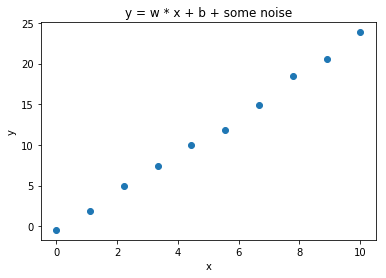

In [70]:
w, b = 2.3, 0.0125
x = torch.linspace(0, 10, 10) # generates 1000 evenly-spaced values from 0 to 10
x = x.view(10, 1)
y = w * x + b + torch.randn(x.size())

plt.scatter(x.numpy(), y.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('y = w * x + b + some noise')

In [71]:
model = LinearModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

model, losses = train(x, y, model, criterion, optimizer, iters=10)

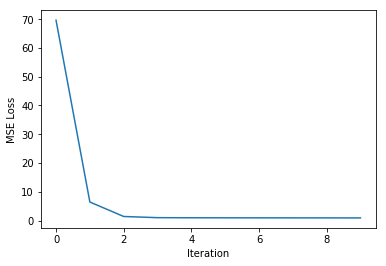

In [72]:
plt.plot(range(iterations), losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')

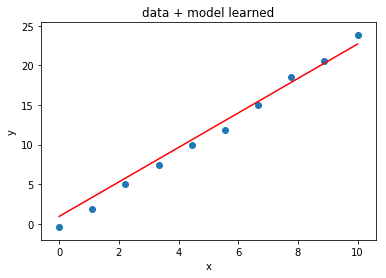

In [73]:
xt = torch.linspace(0, 10, 2)
xt = xt.view(2, 1)
yt = model(Variable(xt))

plt.plot(xt.numpy(), yt.data.numpy(), c='r')
plt.scatter(x.numpy(), y.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('data + model learned')

Now, let's try to approximate a more complicated function. Let $f(x) = sin(x)$


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

For example, look at this network that classifies digit images:

.. figure:: /_static/img/mnist.png
   :alt: convnet

   convnet

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



In [114]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        # 1 input flattened 28 x 28 image (so one vector of 784 elements)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 10) # output into 10 categories

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = FCNet()
print(net)

FCNet (
  (fc1): Linear (784 -> 256)
  (fc2): Linear (256 -> 256)
  (fc3): Linear (256 -> 256)
  (fc4): Linear (256 -> 10)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [80]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

8
torch.Size([256, 1024])


The input to the forward is an ``autograd.Variable``, and so is the output.
Note: Expected input size to this net(LeNet) is 32x32. To use this net on
MNIST dataset, please resize the images from the dataset to 32x32.



In [81]:
input = Variable(torch.randn(1, 1, 32, 32).view(1, -1))
out = net(input)
print(out)

Variable containing:
1.00000e-02 *
 -0.1153 -3.6312  3.1389 -1.2882  0.7563 -1.3771  9.0843  2.8923  0.9255 -9.9242
[torch.FloatTensor of size 1x10]



Zero the gradient buffers of all parameters and backprops with random
gradients:



In [82]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array*.
  -  ``autograd.Variable`` - *Wraps a Tensor and records the history of
     operations* applied to it. Has the same API as a ``Tensor``, with
     some additions like ``backward()``. Also *holds the gradient*
     w.r.t. the tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Variable, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Variable`` operation, creates at
     least a single ``Function`` node, that connects to functions that
     created a ``Variable`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <http://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [ ]:
output = net(input)
target = Variable(torch.arange(1, 11))  # a dummy target, for example
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Variables in the graph will have their
``.grad`` Variable accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [ ]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [ ]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is `here <http://pytorch.org/docs/nn>`_.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

.. Note::

      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in `Backprop`_ section.



Training on MNIST
==========

Now, we'll try to train this fully connected neural network on the MNIST dataset. In MNIST, we are given 32x32 images of numbers and asked to classify them

In [115]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.utils.data as data

In [136]:
batch_size = 32
lr = 1e-2
epochs = 4
log_interval = 1000

In [137]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_loader = data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transform),
    batch_size=batch_size, shuffle=True)

test_loader = data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transform),
    batch_size=batch_size, shuffle=True)

In [138]:
model = FCNet()
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [139]:
def train(epoch):
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.view(X.size(0), -1)
        X, y = Variable(X), Variable(y)
        out = model(X)
        loss = criterion(out, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [146]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for X, y in test_loader:
        X = X.view(X.size(0), -1)
        X, y = Variable(X, volatile=True), Variable(y)
        out = model(X)
        test_loss += criterion(out, y).data[0] # sum up batch loss
        pred = out.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(y.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [147]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.195124
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.121602

Test set: Average loss: 0.0037, Accuracy: 9634/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.017538
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.017533

Test set: Average loss: 0.0035, Accuracy: 9635/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.041178
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.359968

Test set: Average loss: 0.0030, Accuracy: 9701/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.078838
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.090827


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x113366908>>
Traceback (most recent call last):
  File "/Users/wilsonyan/anaconda/envs/torch/lib/python3.6/site-packages/PIL/Image.py", line 571, in __del__
    def __del__(self):
KeyboardInterrupt



Test set: Average loss: 0.0028, Accuracy: 9706/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.037114
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.005621

Test set: Average loss: 0.0028, Accuracy: 9712/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.035260
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.060230

Test set: Average loss: 0.0025, Accuracy: 9751/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.140080
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.033744

Test set: Average loss: 0.0024, Accuracy: 9770/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.025864
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.003745

Test set: Average loss: 0.0026, Accuracy: 9747/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.016089
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.010512

Test set: Average loss: 0.0023, Accuracy: 9760/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.018803
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.122908

Test set: Average loss: 0.0022, Accuracy: 9775/10000 (98%)

